In [84]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from cvxopt import matrix, solvers

class SVM:
    def __init__(self, kernel="linear", C=0 , gamma = 0.1):
        self.kernel = kernel
        self.gamma = gamma
        self.C = C
        self.w = None
        self.b = 0
        self.support_vectors = None
        self.support_vector_labels = None
        self.support_vector_alphas = None
        
    def linear_kernel(self, x1, x2):
        return np.dot(x1, x2)

    def rbf_kernel(self, x1, x2):
        diff = x1 - x2
        return np.exp(-self.gamma * np.dot(diff, diff))
    
    def get_kernel_fn(self):
        if self.kernel == "linear":
            return self.linear_kernel
        elif self.kernel == "rbf":
            return self.rbf_kernel
        raise ValueError(f"Unknown kernel: {self.kernel}")

    def get_alpha(self, X, y):
        y = y.astype(float)
        n_samples, n_features = X.shape
        
        K = np.zeros((n_samples, n_samples))
        kernel_fn = self.get_kernel_fn()
        for i in range(n_samples):
            for j in range(n_samples):
                K[i,j] = kernel_fn(X[i], X[j])
        
        P = matrix(np.outer(y, y) * K, tc='d')
        q = matrix(-np.ones(n_samples), tc='d')
        G = matrix(np.vstack((
            -np.eye(n_samples),
            np.eye(n_samples)
        )), tc='d')
        h = matrix(np.hstack((
            np.zeros(n_samples),
            np.ones(n_samples) * self.C
        )), tc='d')
        A = matrix(y.reshape(1, -1), tc='d')
        b = matrix(0.0, tc='d')
        
        solvers.options['show_progress'] = False
        solution = solvers.qp(P, q, G, h, A, b)
        
        return K, np.array(solution['x']).flatten()

    def fit(self, X, y):
        K, alpha = self.get_alpha(X, y)

        sv_indices = alpha > 0.0001
        self.support_vectors = X[sv_indices]
        self.support_vector_labels = y[sv_indices]
        self.support_vector_alphas = alpha[sv_indices]
        
        if np.sum(sv_indices) > 0:
            sv_mask = sv_indices
            self.b = np.mean(
                y[sv_mask] - 
                np.dot((alpha * y).T, K[:, sv_mask])
            ) # b = y - avg(alpha * y * K ) -> That's the same equation as in the notes; it's just averaged for stabilization.
        else:
            self.b = 0
        
        if self.kernel == "linear":
            self.w = np.sum(alpha.reshape(-1, 1) * y.reshape(-1, 1) * X, axis=0)
        else:
            self.w = None
    
    def decision_function(self, X):
        if self.kernel == "linear":
            return np.dot(X, self.w) + self.b
        else:
            scores = np.zeros(X.shape[0])
            for i in range(X.shape[0]):
                kernel_vals = np.array([
                    self.get_kernel_fn()(self.support_vectors[j], X[i]) 
                    for j in range(len(self.support_vectors))
                ])
                scores[i] = self.b + np.sum(
                    self.support_vector_alphas * 
                    self.support_vector_labels * 
                    kernel_vals
                )
            return scores
    
    def predict(self, X):
        return np.sign(self.decision_function(X))


In [85]:
def plot_decision_boundary(svm, X, y):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 50),
                         np.linspace(y_min, y_max, 50))
    
    Z = svm.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.4)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor='k')
    
    if svm.support_vectors is not None:
        plt.scatter(svm.support_vectors[:, 0], svm.support_vectors[:, 1],
                   s=100, facecolors='none', edgecolors='k')
    
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())


Test accuracy: 1.00


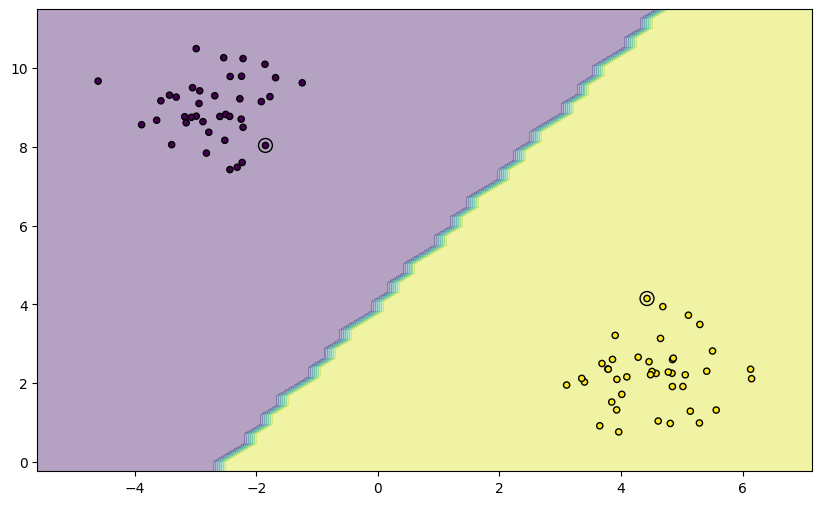

In [86]:
def example():
    X, y = make_blobs(n_samples=100, centers=2, 
                     n_features=2, random_state=42, cluster_std=0.8)
    y = np.where(y == 0, -1, 1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    svm = SVM(kernel="linear", C=1.0)
    svm.fit(X_train, y_train)
    
    y_pred = svm.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Test accuracy: {accuracy:.2f}")
    
    plt.figure(figsize=(10, 6))
    plot_decision_boundary(svm, X_train, y_train)
    plt.show()

example()

Test accuracy: 1.00


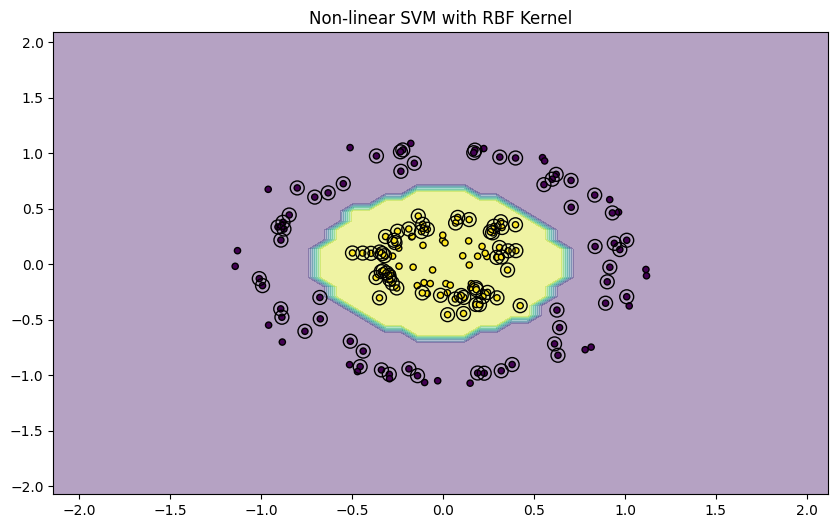

In [87]:
from sklearn.datasets import make_circles

def example_nonlinear():
    X, y = make_circles(n_samples=200, noise=0.1, factor=0.3, random_state=42)
    y = np.where(y == 0, -1, 1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    svm = SVM(kernel="rbf", C = 0.1, gamma = 1)

    svm.fit(X_train, y_train)
    
    y_pred = svm.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"Test accuracy: {acc:.2f}")
    
    plt.figure(figsize=(10, 6))
    plot_decision_boundary(svm, X_train, y_train)
    plt.title("Non-linear SVM with RBF Kernel")
    plt.show()

example_nonlinear()